In [1]:
from pyspark.sql import functions as F
from pyspark.sql import DataFrameNaFunctions as DFna
from pyspark.sql.functions import udf, col, when
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
import pyspark as ps
import os
import sys
import requests
import json
from pyspark.sql import SparkSession

spark = ps.sql.SparkSession.builder \
    .master("local[4]") \
    .appName("building recommender") \
    .getOrCreate()  # create a spark session

sc = spark.sparkContext  # create a spark context

In [2]:
moviesFile = "data/movies/movies.csv"
linksFile = "data/movies/links.csv"
ratingsFile = "data/movies/ratings.csv"
tagsFile = "data/movies/tags.csv"

In [3]:
# read movies CSV
movies_df = spark.read.csv(moviesFile,
                           header=True,       # use headers or not
                           quote='"',         # char for quotes
                           sep=",",           # char for separation
                           inferSchema=True)  # do we infer schema or not ?
movies_df.printSchema()

root
 |-- movieId: integer (nullable = true)
 |-- title: string (nullable = true)
 |-- genres: string (nullable = true)



In [4]:
print("line count: {}".format(movies_df.count()))

line count: 9125


In [5]:
# read ratings CSV
ratings_df = spark.read.csv(ratingsFile,
                            header=True,       # use headers or not
                            quote='"',         # char for quotes
                            sep=",",           # char for separation
                            inferSchema=True)  # do we infer schema or not ?
ratings_df.printSchema()

root
 |-- userId: integer (nullable = true)
 |-- movieId: integer (nullable = true)
 |-- rating: double (nullable = true)
 |-- timestamp: integer (nullable = true)



In [6]:
ratings = ratings_df.rdd

numRatings = ratings.count()
numUsers = ratings.map(lambda r: r[0]).distinct().count()
numMovies = ratings.map(lambda r: r[1]).distinct().count()

print("Got %d ratings from %d users on %d movies." % (numRatings, numUsers, numMovies))

Py4JJavaError: An error occurred while calling z:org.apache.spark.api.python.PythonRDD.collectAndServe.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 7.0 failed 1 times, most recent failure: Lost task 0.0 in stage 7.0 (TID 6) (192.168.1.11 executor driver): java.io.IOException: Cannot run program "C:\Users\LENOVO\AppData\Local\Programs\Python\Python311": CreateProcess error=5, Access is denied
	at java.base/java.lang.ProcessBuilder.start(ProcessBuilder.java:1170)
	at java.base/java.lang.ProcessBuilder.start(ProcessBuilder.java:1089)
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:181)
	at org.apache.spark.api.python.PythonWorkerFactory.create(PythonWorkerFactory.scala:109)
	at org.apache.spark.SparkEnv.createPythonWorker(SparkEnv.scala:124)
	at org.apache.spark.api.python.BasePythonRunner.compute(PythonRunner.scala:174)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:67)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:93)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:161)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1144)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:642)
	at java.base/java.lang.Thread.run(Thread.java:1583)
Caused by: java.io.IOException: CreateProcess error=5, Access is denied
	at java.base/java.lang.ProcessImpl.create(Native Method)
	at java.base/java.lang.ProcessImpl.<init>(ProcessImpl.java:500)
	at java.base/java.lang.ProcessImpl.start(ProcessImpl.java:159)
	at java.base/java.lang.ProcessBuilder.start(ProcessBuilder.java:1126)
	... 19 more

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2844)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2780)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2779)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2779)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1242)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1242)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1242)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:3048)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2982)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2971)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:984)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2398)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2419)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2438)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2463)
	at org.apache.spark.rdd.RDD.$anonfun$collect$1(RDD.scala:1046)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:407)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:1045)
	at org.apache.spark.api.python.PythonRDD$.collectAndServe(PythonRDD.scala:195)
	at org.apache.spark.api.python.PythonRDD.collectAndServe(PythonRDD.scala)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:75)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:52)
	at java.base/java.lang.reflect.Method.invoke(Method.java:580)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:1583)
Caused by: java.io.IOException: Cannot run program "C:\Users\LENOVO\AppData\Local\Programs\Python\Python311": CreateProcess error=5, Access is denied
	at java.base/java.lang.ProcessBuilder.start(ProcessBuilder.java:1170)
	at java.base/java.lang.ProcessBuilder.start(ProcessBuilder.java:1089)
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:181)
	at org.apache.spark.api.python.PythonWorkerFactory.create(PythonWorkerFactory.scala:109)
	at org.apache.spark.SparkEnv.createPythonWorker(SparkEnv.scala:124)
	at org.apache.spark.api.python.BasePythonRunner.compute(PythonRunner.scala:174)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:67)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:93)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:161)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1144)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:642)
	... 1 more
Caused by: java.io.IOException: CreateProcess error=5, Access is denied
	at java.base/java.lang.ProcessImpl.create(Native Method)
	at java.base/java.lang.ProcessImpl.<init>(ProcessImpl.java:500)
	at java.base/java.lang.ProcessImpl.start(ProcessImpl.java:159)
	at java.base/java.lang.ProcessBuilder.start(ProcessBuilder.java:1126)
	... 19 more


In [7]:
movies_counts = ratings_df.groupBy(col("movieId")).agg(
    F.count(col("rating")).alias("counts"))


movies_counts.show()

+-------+------+
|movieId|counts|
+-------+------+
|   1580|   190|
|   2659|     3|
|   3794|     5|
|   3175|    65|
|    471|    49|
|   1088|    53|
|   1342|    17|
|   1645|    60|
|   2366|    23|
|   6620|    17|
|   8638|    17|
|  96488|     4|
| 160563|     2|
|   7982|     3|
|   1238|    17|
|   1959|    30|
|    463|     7|
|   2122|    11|
|   1591|    15|
|   5518|     1|
+-------+------+
only showing top 20 rows



In [8]:
ratings_df.take(3)

[Row(userId=1, movieId=31, rating=2.5, timestamp=1260759144),
 Row(userId=1, movieId=1029, rating=3.0, timestamp=1260759179),
 Row(userId=1, movieId=1061, rating=3.0, timestamp=1260759182)]

In [9]:
training_df, validation_df, test_df = ratings_df.randomSplit([.6, .2, .2], seed=0)
# training_RDD = training_RDD.rdd.cache()
# validation_for_predict_RDD = validation_RDD.rdd.map(lambda x: (x[0], x[1])).cache()
# test_for_predict_RDD = test_RDD.rdd.map(lambda x: (x[0], x[1])).cache()
training_df

DataFrame[userId: int, movieId: int, rating: double, timestamp: int]

In [10]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml import Pipeline
from pyspark.sql import Row
import numpy as np
import math

In [11]:
seed = 5
iterations = 10
regularization_parameter = 0.1
ranks = range(4, 12)
errors = []
err = 0
tolerance = 0.02

In [12]:
min_error = float('inf')
best_rank = -1
best_iteration = -1

for rank in ranks:
    als = ALS(maxIter=iterations, regParam=regularization_parameter, rank=rank, userCol="userId", itemCol="movieId", ratingCol="rating")
    model = als.fit(training_df)
    predictions = model.transform(validation_df)
    new_predictions = predictions.filter(col('prediction') != np.nan)
    evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")
    rmse = evaluator.evaluate(new_predictions)
    errors.append(rmse)

    print ('For rank %s the RMSE is %s' % (rank, rmse))
    if rmse < min_error:
        min_error = rmse
        best_rank = rank
print ('The best model was trained with rank %s' % best_rank)



For rank 4 the RMSE is 0.9411890212713474
For rank 5 the RMSE is 0.9466874112259057
For rank 6 the RMSE is 0.9450579849289905
For rank 7 the RMSE is 0.9498340706794443
For rank 8 the RMSE is 0.9410617504344562
For rank 9 the RMSE is 0.9506511062323584
For rank 10 the RMSE is 0.9439989950544326
For rank 11 the RMSE is 0.9483491439130853
The best model was trained with rank 8


In [27]:
als = ALS(maxIter=iterations, regParam=regularization_parameter,
          rank=rank, userCol="userId", itemCol="movieId", ratingCol="rating")

paramGrid = ParamGridBuilder() \
    .addGrid(als.regParam, [0.1, 0.01]) \
    .addGrid(als.rank, range(4, 12)) \
    .build()

evaluator = RegressionEvaluator(
    metricName="rmse", labelCol="rating", predictionCol="prediction")

crossval = CrossValidator(estimator=als,

                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,

                          numFolds=5)

cvModel = crossval.fit(training_df)

In [28]:
cvModel_pred = cvModel.transform(validation_df)
cvModel_pred = cvModel_pred.filter(col('prediction') != np.nan)
rmse = evaluator.evaluate(cvModel_pred)
print ("the rmse for optimal grid parameters with cross validation is: {}".format(rmse))

the rmse for optimal grid parameters with cross validation is: 0.9408568433459146


In [29]:
final_als = ALS(maxIter=10, regParam=0.1, rank=6, userCol="userId", itemCol="movieId", ratingCol="rating")
final_model = final_als.fit(training_df)
final_pred = final_model.transform(validation_df)
final_pred = final_pred.filter(col('prediction') != np.nan)
rmse = evaluator.evaluate(final_pred)
print( "the rmse for optimal grid parameters with cross validation is: {}".format(rmse))

the rmse for optimal grid parameters with cross validation is: 0.9406684919098017


In [30]:
# read links CSV
links_df = spark.read.csv(linksFile,
                          header=True,       # use headers or not
                          quote='"',         # char for quotes
                          sep=",",           # char for separation
                          inferSchema=True)  # do we infer schema or not ?
links_df.printSchema()

root
 |-- movieId: integer (nullable = true)
 |-- imdbId: integer (nullable = true)
 |-- tmdbId: integer (nullable = true)



In [31]:
np.random.seed(42)
user_id = np.random.choice(numUsers)

NameError: name 'numUsers' is not defined

In [ ]:
new_user_ratings = ratings_df.filter(ratings_df.userId == user_id)
new_user_ratings.sort('rating', ascending=True).take(
    10)  # top rated movies for this user

[Row(userId=102, movieId=37, rating=1.0, timestamp=959976593),
 Row(userId=102, movieId=1888, rating=1.0, timestamp=957895013),
 Row(userId=102, movieId=2240, rating=1.0, timestamp=957894741),
 Row(userId=102, movieId=2541, rating=1.0, timestamp=957894760),
 Row(userId=102, movieId=2548, rating=1.0, timestamp=957980378),
 Row(userId=102, movieId=3354, rating=1.0, timestamp=957893451),
 Row(userId=102, movieId=3484, rating=1.0, timestamp=957893428),
 Row(userId=102, movieId=3511, rating=1.0, timestamp=957893428),
 Row(userId=102, movieId=1584, rating=2.0, timestamp=957894285),
 Row(userId=102, movieId=590, rating=2.0, timestamp=957894532)]

In [ ]:
new_user_ratings.describe('rating').show()

+-------+------------------+
|summary|            rating|
+-------+------------------+
|  count|               678|
|   mean|3.9749262536873156|
| stddev|0.8529848074277973|
|    min|               1.0|
|    max|               5.0|
+-------+------------------+



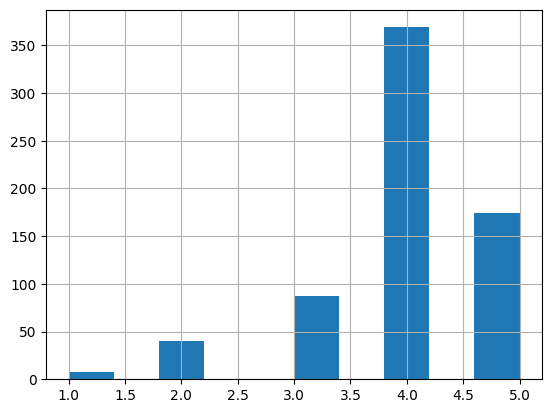

In [ ]:
new_user_ratings.toPandas()['rating'].hist()
plt.show()

In [ ]:
new_user_rated_movieIds = [
    i.movieId for i in new_user_ratings.select('movieId').distinct().collect()]
movieIds = [i.movieId for i in movies_counts.filter(
    movies_counts.counts > 25).select('movieId').distinct().collect()]


new_user_unrated_movieIds = list(set(movieIds) - set(new_user_rated_movieIds))

In [ ]:
import time
num_ratings = len(new_user_unrated_movieIds)
cols = ('userId', 'movieId', 'timestamp')
timestamps = [int(time.time())] * num_ratings
userIds = [user_id] * num_ratings
# ratings = [0] * num_ratings
new_user_preds = spark.createDataFrame(
    zip(userIds, new_user_unrated_movieIds, timestamps), cols)

In [ ]:
new_user_preds = final_model.transform(
    new_user_preds).filter(col('prediction') != np.nan)

In [ ]:
new_user_preds.sort('prediction', ascending=False).take(10)

[Row(userId=102, movieId=306, timestamp=1704513311, prediction=4.899744033813477),
 Row(userId=102, movieId=56782, timestamp=1704513311, prediction=4.796440124511719),
 Row(userId=102, movieId=55820, timestamp=1704513311, prediction=4.7642717361450195),
 Row(userId=102, movieId=1206, timestamp=1704513311, prediction=4.75372314453125),
 Row(userId=102, movieId=1254, timestamp=1704513311, prediction=4.734280586242676),
 Row(userId=102, movieId=951, timestamp=1704513311, prediction=4.649381160736084),
 Row(userId=102, movieId=1041, timestamp=1704513311, prediction=4.57188606262207),
 Row(userId=102, movieId=6016, timestamp=1704513311, prediction=4.5613813400268555),
 Row(userId=102, movieId=1199, timestamp=1704513311, prediction=4.557847023010254),
 Row(userId=102, movieId=4848, timestamp=1704513311, prediction=4.5051116943359375)]

In [ ]:
# Get base url filepath structure. w185 corresponds to size of movie poster.
api_key = "b3dadf36f3a54b7e016ecb826e0ec0a1"

headers = {'Accept': 'application/json'}
payload = {'api_key': api_key}
response = requests.get(
    "http://api.themoviedb.org/3/configuration", params=payload, headers=headers)
response = json.loads(response.text)
base_url = response['images']['base_url'] + 'w185'


def get_poster(tmdb_id, base_url):
    # Query themoviedb.org API for movie poster path.
    movie_url = 'http://api.themoviedb.org/3/movie/{:}/images'.format(tmdb_id)
    headers = {'Accept': 'application/json'}
    payload = {'api_key': api_key}
    try:
      response = requests.get(movie_url, params=payload, headers=headers)
      file_path = json.loads(response.text)['posters'][0]['file_path']
      return base_url + file_path
    except:
      return ""

In [ ]:
from IPython.display import Image
from IPython.display import display

In [ ]:
new_user_ratings = new_user_ratings.sort('rating', ascending=False).join(
    links_df, new_user_ratings.movieId == links_df.movieId)

In [ ]:
posters = tuple(Image(url=get_poster(movie.tmdbId, base_url)) for movie in new_user_ratings.take(10))

In [ ]:
display(*posters)

In [ ]:
new_user_preds = new_user_preds.sort('prediction', ascending=False).join(
    links_df, new_user_preds.movieId == links_df.movieId)

In [ ]:
posters = tuple(Image(url=get_poster(movie.tmdbId, base_url))
                for movie in new_user_preds.take(10))

In [ ]:
display(*posters)

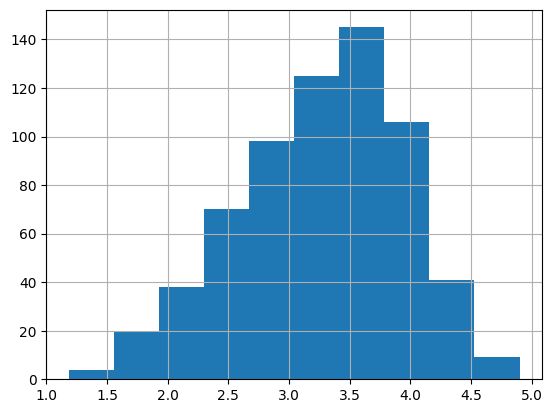

In [ ]:
new_user_preds.toPandas()['prediction'].hist()
plt.show()